## Data preprocessing

In order to run SANGO, we need to first create anndata from the raw data.

The h5ad file should have cells as obs and peaks as var. There should be at least three columns in var: chr, start, end that indicate the genomic region of each peak.

Notice that we filter out peaks accessible in < 1% cells for optimal performance.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import pandas as pd
import numpy as np

### load data

In [2]:
adata = sc.read_h5ad("data/reference_query_example.h5ad")
print(np.unique(adata.obs["Batch"]))

['query' 'reference']


### filtering and saving data

In [3]:
def make_anndata(adata, chrom, start, end, path):
    adata.var['chr'] = chrom
    adata.var['start'] = start
    adata.var['end'] = end

    # basic stats
    sc.pp.filter_cells(adata, min_genes=0)
    sc.pp.filter_genes(adata, min_cells=0)

    # a peak need to be accessible in 1% cells
    thres = int(adata.shape[0]*0.01)
    adata = adata[:, adata.var['n_cells']>thres]

    chrs = ['chr'+str(i) for i in range(1,23)] + ['chrX', 'chrY']
    adata = adata[:, adata.var['chr'].isin(chrs)]
    
    print(adata)
    adata.write(path)
    return adata

In [4]:
adata_reference = adata[adata.obs["Batch"] == "reference"]
adata_query = adata[adata.obs["Batch"] == "query"]

concat_adata = sc.AnnData.concatenate(adata_reference, adata_query)
print(concat_adata)

concat_adata = make_anndata(
    concat_adata,
    concat_adata.var["chrom"],
    concat_adata.var["chromStart"],
    concat_adata.var["chromEnd"],
    "preprocessed_data/reference_query_example.h5ad",
)

AnnData object with n_obs × n_vars = 10537 × 436206
    obs: 'cell', 'tissue', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'Batch', 'CellType', 'batch'
    var: 'chrom', 'chromStart', 'chromEnd'
View of AnnData object with n_obs × n_vars = 10537 × 99915
    obs: 'cell', 'tissue', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'Batch', 'CellType', 'batch', 'n_genes'
    var: 'chrom', 'chromStart', 'chromEnd', 'chr', 'start', 'end', 'n_cells'


## Run CACNN

In [5]:
%cd SANGO/CACNN

/data/user/luomai/SANGO/SANGO/CACNN


In [6]:
!python main.py -i ../../preprocessed_data/reference_query_example.h5ad \
                -g mm9 \
                -o ../../output/reference_query_example

INFO(20230929 13:00:58) [main.py:72]:
##time: Fri Sep 29 13:00:58 2023
##cwd: /data/user/luomai/SANGO/SANGO/CACNN
##cmd: main.py -i ../../preprocessed_data/reference_query_example.h5ad -g mm9 -o ../../output/reference_query_example
##args: Namespace(alpha=0.0, batch_size=128, data='../../preprocessed_data/reference_query_example.h5ad', device=0, g='mm9', lr=0.01, max_epoch=300, num_workers=32, outdir='../../output/reference_query_example', seed=2020, seq_len=1344, use_reg_cell=False, w=False, z=64)
Calculating AP: 100%|██████████████████████| 2000/2000 [00:05<00:00, 347.98it/s]
INFO(20230929 13:02:17) [main.py:148]:Validation1 AUC=0.7731/0.0714
INFO(20230929 13:02:18) [main.py:155]:Epoch 1: best model saved

Calculating AP: 100%|██████████████████████| 2000/2000 [00:05<00:00, 347.31it/s]
INFO(20230929 13:03:30) [main.py:148]:Validation2 AUC=0.7747/0.0696
INFO(20230929 13:03:30) [main.py:155]:Epoch 2: best model saved

Calculating AP: 100%|██████████████████████| 2000/2000 [00:05<00:00,

## Run GraphTransFormer

In [7]:
%cd ../GraphTransformer

/data/user/luomai/SANGO/SANGO/GraphTransformer


In [8]:
!python main.py --data_dir ../../output/reference_query_example/CACNN_output.h5ad \
                --train_name_list reference --test_name query \
                --save_path ../../output \
                --save_name reference_query_example

Namespace(K=10, M=30, batch_size=50000, cpu=False, data_dir='../../output/reference_query_example/CACNN_output.h5ad', device=0, dropout=0.0, edge_ratio=0.0, epochs=300, eval_step=1, hidden_channels=64, lamda=1.0, lr=0.001, metric='acc', num_heads=4, num_layers=3, rb_order=2, rb_trans='sigmoid', runs=1, sample_ratio=0.1, save_name='reference_query_example', save_path='../../output', seed=42, tau=0.25, test_name=['query'], train_name_list=['reference'], train_prop=0.5, use_act=False, use_bn=True, use_gumbel=True, use_jk=False, use_residual=True, valid_prop=0.25, weight_decay=0.005)
shape of train data:
	(4370, 64)
shape of concat train data:
	(4370, 64)
shape of test data:
	(6167, 64)
shape of concat test data:
	(6167, 64)
----------after remove unknown----------
shape of train data: (4189, 64)
shape of test data: (6122, 64)
----------after remove rare----------
shape of train data: (4179, 64)
shape of test data: (6095, 64)
----------after intersect----------
shape of train data: (4179, 

## Visualization

### Umap

In [10]:
%cd ../../

/data/user/luomai/SANGO


<Figure size 7680x5760 with 0 Axes>

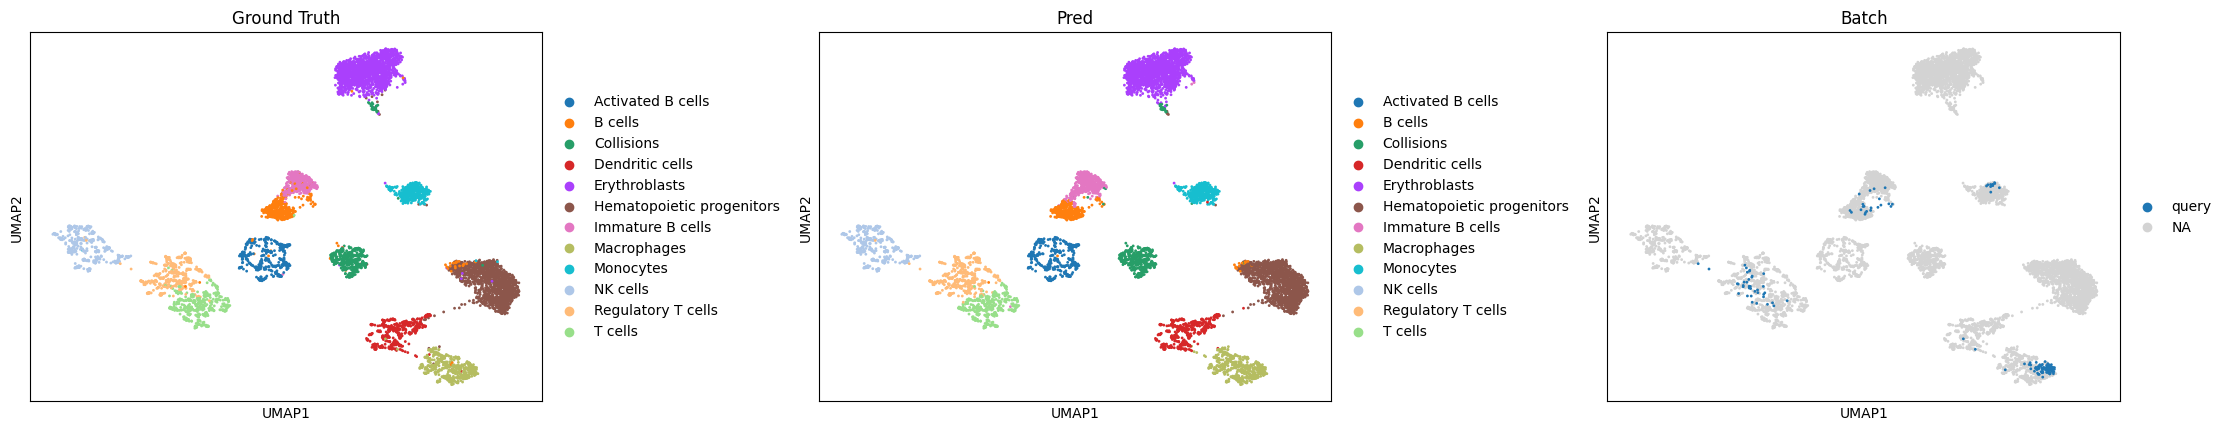

In [13]:
import matplotlib.pyplot as plt

adata = sc.read_h5ad("output/reference_query_example/embedding.h5ad")

fontsize = 10
plt.figure(dpi=1200)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X', n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["CellType", "Pred", "Batch"], title=["Ground Truth", "Pred", "Batch"],
            legend_fontsize=fontsize,
            wspace=0.4)

<Figure size 7680x5760 with 0 Axes>

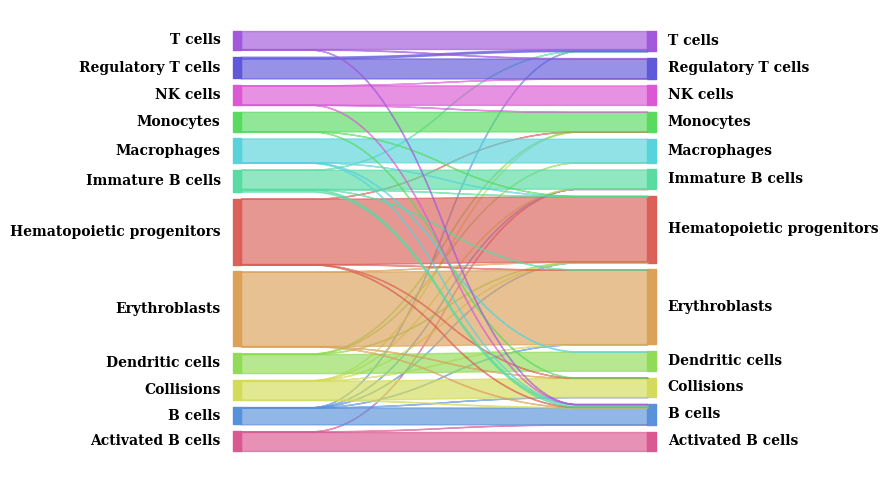

In [14]:
from pySankey.sankey import sankey

pred_col = 'Pred'
true_col = 'CellType'

plt.rcParams['font.weight'] = "heavy"
plt.figure(dpi=1200)
sankey(
    adata.obs[pred_col], adata.obs[true_col], aspect=10,
    fontsize=10, leftLabels = list(np.unique(adata.obs[pred_col])), rightLabels = list(np.unique(adata.obs[true_col]))
    )